### data source [here]( https://www.kaggle.com/c/nlp-getting-started/data)

In [14]:
import pandas as pd # our main data management package
import matplotlib.pyplot as plt # our main display package
import string # used for preprocessing
import re # used for preprocessing
import nltk # the Natural Language Toolkit, used for preprocessing
import numpy as np # used for managing NaNs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # our model
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wunderbarx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from prefect import task, Flow, Parameter, Task
from prefect.engine.executors import DaskExecutor

In [16]:
@task
def extract_train_data(data):
    print("fetching data from {0}\n".format(data))
    return pd.read_csv(data)

@task
def extract_test_data(data):
    print("fetching data from {0}\n".format(data))
    return pd.read_csv(data)

In [17]:
@task
def transform_train(train):
    return train.drop(['keyword', 'location'], axis = 1)

In [18]:
class Preparation(Task):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    # remove urls, handles, and the hashtag from hashtags (taken from https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression)
    def remove_urls(self, text):
        new_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
        return new_text

    def text_lowercase(self, text):
        return text.lower()

    def remove_numbers(self, text):
        result = re.sub(r'\d+', '', text)
        return result

    def remove_punctuation(self, text):
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)

    def tokenize(self, text):
        text = word_tokenize(text)
        return text

    def remove_stopwords(self, text):
        text = [i for i in text if not i in self.stop_words]
        return text
    
    def lemmatize(self, text):
        text = [self.lemmatizer.lemmatize(token) for token in text]
        return text
    
    def preprocessing(self, text):
        text = self.text_lowercase(text)
        text = self.remove_urls(text)
        text = self.remove_numbers(text)
        text = self.remove_punctuation(text)
        text = self.tokenize(text)
        text = self.remove_stopwords(text)
        text = self.lemmatize(text)
        text = ' '.join(text)        
        return text

    def add_to_df(self, df):      
        pp_text = [] # our preprocessed text column
        for text_data in df['text']:
            pp_text_data = self.preprocessing(text_data)
            pp_text.append(pp_text_data)
        df['pp_text'] = pp_text # add the preprocessed text as a column
        
        return df
    
    def run(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.add_to_df(df);

train_preparation = Preparation(name="Train Preparation")
test_preparation = Preparation(name="Test Preparation")

In [19]:
@task
def vectorization(train, test):
    print("Vectorization...")
    corpus = list(train['pp_text']) + list(test['pp_text'])
    tf = TfidfVectorizer()
    # the vectorizer must be fit onto the entire corpus
    fitted_vectorizer = tf.fit(corpus)
    
    # train
    train_transform = fitted_vectorizer.transform(train['pp_text'])
    y = train['target']
    
    # test
    test_transform = fitted_vectorizer.transform(test['pp_text'])
    
    return train_transform, y, test_transform

In [20]:
@task
def train_split(X,y):
    return train_test_split(X, y)

In [21]:
@task
def modeling(X_train, y_train):
    scikit_log_reg = LogisticRegression()
    model = scikit_log_reg.fit(X_train, y_train)
    return model  

In [22]:
@task(name="prediction")
def prediction(model, test):
    return model.predict(test)

In [23]:
@task(name="score")
def score(predictions, y_test):
    count = 0
    for guess, answer in zip(predictions, y_test):
        if guess == answer:
            count += 1
    print(count/len(y_test),"\n")  

In [24]:
with Flow("twitter disaster classification") as flow:
    # set parameters
    train_p = Parameter("train", default="data/train.csv")
    test_p = Parameter("test", default="data/test.csv")
    submission = Parameter("submission", default="data/sample_submission.csv")
    
    # extract
    train = extract_train_data(train_p)
    test = extract_test_data(test_p)
    submission = extract_test_data(submission)
    
    # transform train   
    train_trasformed = transform_train(train)
    
    # preparation
    preprocessed_train = train_preparation(train_trasformed)
    preprocessed_test = test_preparation(test)
    
    # vectorization
    vectorized = vectorization(preprocessed_train, preprocessed_test)
    X = vectorized[0]
    y = vectorized[1]
    Z = vectorized[2]
  
    # train split
    splitted = train_split(X, y)
    X_train = splitted[0]
    X_test = splitted[1]
    
    y_train = splitted[2]
    y_test = splitted[3]
    
    # modeling
    model = modeling(X_train, y_train)
    
    # predicion
    predictions_train = prediction(model, X_test, task_args={'name':'train predicion'})
    predictions_test = prediction(model, Z, task_args={'name':'test predicion'})
    
    # score
    score(predictions_train, y_test, task_args={'name':'y_train score'})
    score(predictions_test, submission['target'], task_args={'name':'y_test score'})

In [25]:
flow.run(executor=DaskExecutor())

[2020-06-05 17:12:43] INFO - prefect.FlowRunner | Beginning Flow run for 'twitter disaster classification'
[2020-06-05 17:12:43] INFO - prefect.FlowRunner | Starting flow run.
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'train': Starting task run...
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'test': Starting task run...
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'submission': Starting task run...
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'train': finished task run for task with final state: 'Success'
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'test': finished task run for task with final state: 'Success'
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'submission': finished task run for task with final state: 'Success'
[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'extract_train_data': Starting task run...
fetching data from data/train.csv

[2020-06-05 17:12:44] INFO - prefect.TaskRunner | Task 'extract_test_da

<Success: "All reference tasks succeeded.">

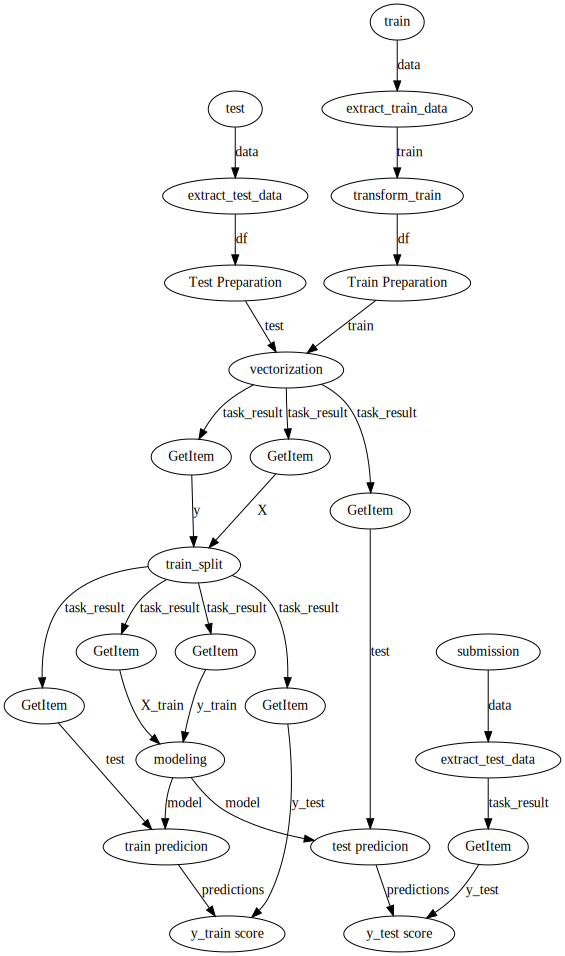

In [26]:
flow.visualize()